# Progetto Business Intelligence per i Servizi Finanziari (a.a. 2023-2024)
Luca Pinciroli 885969

Per prima cosa importiamo le librerie che serviranno a compiere tutte le operazioni necessarie.

In [19]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

Dopodiché creiamo una semplice funzione che consente di scaricare i dati giornalieri di un'azione da Yahoo Finance e salvarli in formato CSV per averli sempre a disposizione.

In [20]:
def get_stock_data(ticker, start_date, end_date):
    
    data_dir = "StockData" # Nome della cartella per i file CSV
    os.makedirs(data_dir, exist_ok=True)
    
    
    csv_file = os.path.join(data_dir, f"{ticker}.csv") # Nome del file CSV basato sul ticker
    
    # Funzione per caricare i dati dal CSV
    def load_from_csv():
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            df = df.loc[start_date:end_date]
            return df
        except (FileNotFoundError, pd.errors.EmptyDataError):
            return None
    
    # Funzione per scaricare i dati da Yahoo Finance e salvarli in un CSV
    def download_from_yahoo():
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_csv(csv_file)
        return df
    
    data = load_from_csv()
    
    if data is None or data.empty:
        data = download_from_yahoo()
    
    return data

Scarichiamo i dati dei titoli scelti e creiamo un nuovo DataFrame contenente i prezzi di chiusura degli ultimi 10 anni di ciascun titolo.

In [21]:
start = dt.datetime(2014,5,31)
end = dt.datetime(2024,5,31)

tickers = ['AAPL', 'INTC', 'AMZN', 'WMT', 'V', 'MA']
data_frames = []

for ticker in tickers:
    df = get_stock_data(ticker, start, end)
    data_frames.append(df['Adj Close'].rename(ticker))
    
all_stocks_prices = pd.concat(data_frames, axis=1)

all_stocks_prices

,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-02,19.859398,20.772066,15.442000,20.799509,49.775650,72.443565
2014-06-03,20.140236,21.076870,15.359500,20.785961,49.262760,71.785408
2014-06-04,20.370214,21.031145,15.339000,20.899773,49.288418,71.757202
2014-06-05,20.450140,21.076870,16.178499,20.951252,49.472580,72.246124
2014-06-06,20.393904,21.465481,16.483500,20.921448,49.654419,72.838463
...,...,...,...,...,...,...
2024-05-23,186.880005,30.080000,181.050003,64.839996,274.230011,451.209991
2024-05-24,189.979996,30.719999,180.750000,65.379997,274.489990,451.179993
2024-05-28,189.990005,31.059999,182.149994,65.040001,270.980011,445.079987


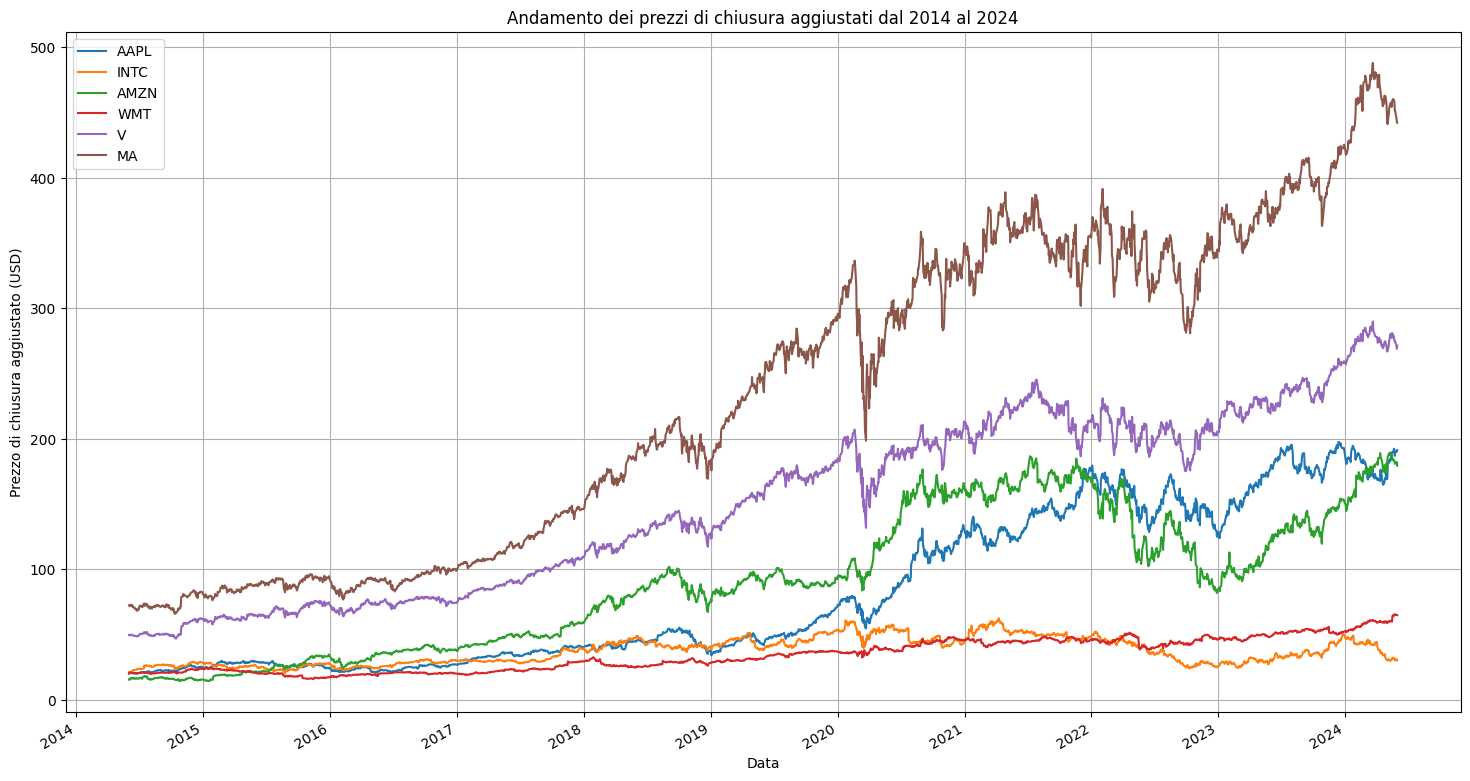

In [24]:
all_stocks_prices.plot(figsize=(18, 10))
plt.title('Andamento dei prezzi di chiusura aggiustati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura aggiustato (USD)')
plt.legend()
plt.grid(True)
plt.show()